In [1]:
include("package.jl")
include("kagome_setup.jl")
include("KH_hamiltonian.jl")

KH_Hamiltonian (generic function with 1 method)

This is the Finite-temperature ED code for Kitaev-Heisernberg model on $2 \times 2 \times 3$ Kagome lattice, in which the periodic boundary condition is used. If we replace the summation of $N_s$ by $R$ times random sampling and the original Hilbert space by $M$-dimentional Krylov space, the partition function can be written as:

\begin{equation}
    Z(T) = \frac{N_s}{R} \sum_{r=1}^{R} \sum_{j=1}^{M-1} e^{-\beta E_j^r} | \langle Vr | \psi_j^r \rangle |^2
\end{equation}
where $| V_r \rangle $ is a normalized random initial vector.

The basic claim of Finite-temperature Lanczos Method(FTLM) is that very accurate results can be obtained for severly reduced number of Lanczos step $M \ll N_s$ and random sampling $R \ll N_s$. 

In [2]:
function random_init(N::Int) 
    vr = rand(Float64, N)
    vr = vr/norm(vr)
    return vr
end

function Schmidt(basis::AbstractMatrix, M::Integer)
    vec = basis[:, M]
    for i = 1:M-1
        basis[:,i] = basis[:,i]
        qi = basis[:,i]' * basis[:,M]
        vec -= qi * basis[:,i]
    end
    return norm(vec), vec/norm(vec)
end

Schmidt (generic function with 1 method)

In [67]:
function Lanczos(A::AbstractMatrix, nev = 50, maxiter = 15)
    """Simple Lanczos(Sandvik2001Computational): Renormalized Lanczos"""
    dim = size(A)[1] 
    ncv = min(nev, dim)
    v0 = random_init(dim) # random initiation vector
    Tri, basis  = zeros(ncv, ncv), zeros(dim, nev) # tridiagonal matrix and corresponding Krylov basis
    error = 1.e-5
    
    basis[:,1] = v0
    for i = 1: ncv-1
        Tri[i,i] += basis[:,i]' * A * basis[:,i] # Definition
        if i == 1
            basis[:,i+1] = A * basis[:,i] - Tri[i,i] * basis[:,i]
        else
            basis[:,i+1] =  A * basis[:,i] - Tri[i,i] * basis[:,i] - Tri[i-1,i]* basis[:,i-1]
        end
        n = norm(basis[:,i+1])
        basis[:,i+1] = basis[:,i+1]/n  # 1st normalize

        
       """Check orthogonality of i-1, i, i+1
        if i==1
            println("Check orthogonality of ", i, ", " , i+1 )
            overlap = basis[:, i+1]' * basis[:, i]
            if abs(overlap) > error
                println("overlap of ", i, " and " , i+1, "= ", overlap)
            else
                println(i, " and " , i+1, " are orthogonal. ")
            end
        else
            println("Check orthogonality of ", i-1, ", " , i, ", ",i+1 )
            for j = i:i+1
                overlap = basis[:, j-1]' * basis[:, j]
                if abs(overlap) > error
                    println("overlap of ", j-1, " and " , j, "= ", overlap)
                else
                    println(j-1, " and " , j, " are orthogonal. ")
                end
            end
        end"""

        """Check orthogonality of i+1 and all previous vectors"""
        M = 0
        factor = n
        while M <= maxiter
            #println("Check orthogonality of ", i+1, " to ", 1)
            count = 0
            for j = 1:i
                overlap = basis[:,j]' * basis[:, i+1]
                if abs(overlap) > error
                    #println("overlap of ", j, " and " , i+1, "= ", overlap)
                else
                    count += 1
                end
            end
            
            if count == i
                if i+1 == ncv
                    println(i+1," is orthogonal with all 1 to ",i)
                    println("Iteration step = ", M)
                end
                break
            else
                """Schmidt""" 
                #println(M+1, "-th Schmidt orthogonality of ", i+1)
                for j = 1:i  
                    qj = basis[:,j]' * basis[:, i+1]
                    basis[:,i+1] -=  qj * basis[:,j]
                    Tri[j, i] += qj * factor
                end
                q = norm(basis[:,i+1])
                basis[:,i+1] = basis[:, i+1]/q
                factor = factor * q
                M += 1
            end
        end
        Tri[i,i+1] = basis[:,i]'* A * basis[:,i+1]
        if M > maxiter
            println(i+1, "exceeds maximum interation step!")
        end

    end
    Tri[ncv, ncv] = basis[:,ncv]' * A * basis[:,ncv]
    
    for j = 1: ncv-1, i= j+1:ncv
        Tri[i,j] = Tri[j,i]
    end
    return Tri, basis
end


Lanczos (generic function with 3 methods)

In [68]:
"""Test GS energy of K-H model"""
Theta = [x for x in LinRange(-1,1,101)]
la = Lattice(1,2)
dim = dimension(la)
eng = zeros(101)
for i = 1:101
    θ= Theta[i]
    J = cospi(θ) * ones(3)
    K = sinpi(θ) * ones(3)
    Hk = Kitaev(K, la)
    Hh = Heisenberg(J, la)
    Htot = Hk + Hh
    v0 = random_init(dim)
    tri, basis = Lanczos(Htot, dim, 200)
    e = eigvals(tri)
    eng[i] = minimum(e)/12
end
println("Finish!")

64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration step = 2
64 is orthogonal with all 1 to 63
Iteration st

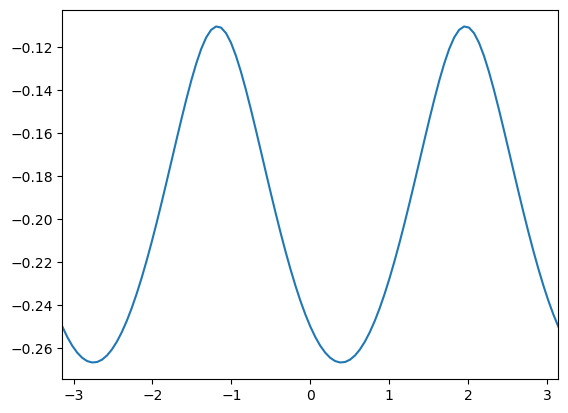

(-3.141592653589793, 3.141592653589793)

In [69]:
plot(Theta*pi, eng)
xlim(-pi,pi)

In [71]:
tri - tri'

UndefVarError: UndefVarError: tri not defined